In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from opt import generate_exclusion_list
from theano import tensor as T

sns.set_context('paper', font_scale=1.5)

/anaconda2/envs/compgen/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
proc_data = pd.read_pickle('data/exp1_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(proc_data, training_contexts=5, goal_chance=1/3.)
for e in excluded:
    proc_data = proc_data[proc_data.subj != e]
uids = list(set(proc_data.subj))
print len(uids)

100%|██████████| 149/149 [01:41<00:00,  1.37it/s]


N clusters = 2, Covarainace = diag
115


# Analyses

In [3]:
proc_data['Accuracy'] = proc_data['Reward'] / 10.0
proc_data['Training'] = proc_data.loc[:, 'Context'] < 6

Below, we plot the training data as a check that subjects learned the task

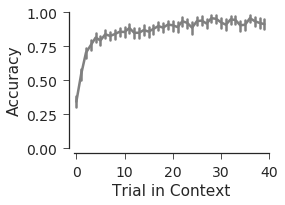

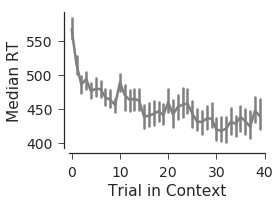

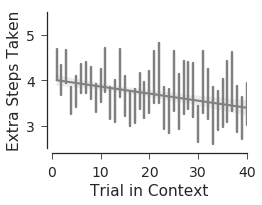

In [36]:
import scipy.stats
color = 'grey'
figsize = (3.5, 2.5)

with sns.axes_style('ticks'):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='Accuracy', 
                  data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                  ax=ax, markers=' ', color=color)
    lb, ub = ax.get_xlim()
    lb, ub = int(lb), int(ub)
    step = 10
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([0, 1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    plt.savefig('exp1_training_acc.png', dpi=300, bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='rt', data=proc_data[proc_data['Training']], 
                  estimator=np.median, ax=ax,  markers=' ', color=color)
    ax.set_ylabel('Median RT')
    ax.set_xlabel('Trial in Context')
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    sns.despine(offset=5)
    plt.savefig('exp1_training_rt.png', dpi=300, bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.regplot(x='Times Seen Context', y='Normalized Steps Taken',
                x_estimator=np.mean,
                data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                truncate=True,
                ax=ax, marker= ' ', color=color)
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([2.5, 5.5])
    ax.set_xlim([lb, ub+1])
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylabel('Extra Steps Taken')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    plt.savefig('exp1_training_steps.png', dpi=300, bbox_inches='tight')

In [5]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii
n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_train_acc:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps',  mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_train_acc = pm.sample()
    
pm.stats.summary(trace_train_acc, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 1000/1000 [06:29<00:00,  2.57it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.108675,0.005226,0.000177,0.09759,0.118123,841.0,0.999252
beta_reps,1.107543,0.057607,0.001630,1.00439,1.230226,1000.0,1.001213


In [6]:
y = np.array(1. / X0['rt'].values)
y = (y - y.mean()) / y.std()

with pm.Model() as glm_rt:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps',  mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat =  b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    # inference
    trace_rt = pm.sample()
    
pm.stats.summary(trace_rt, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.007632,0.000685,0.000028,0.006265,0.008911,491.0,0.999004
beta_reps,0.054935,0.017404,0.000580,0.021795,0.087708,1000.0,0.999318


In [7]:
y = np.array(X0['Normalized Steps Taken'].values)

with pm.Model() as glm_steps:
    
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=1.)  # have to use a more restrictive prior for the Poisson regression
    b_cr = pm.Normal('beta_reps',  mu=0., sd=1.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0.,   sd=1.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=1.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)

    # define linear model and exp link function
    theta = b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
            
    ## Define Poisson likelihood
    y_hat = pm.Poisson('y', mu=np.exp(theta), observed=y)
    
    # inference
    trace_steps = pm.sample()
    
pm.stats.summary(trace_steps, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]
The acceptance probability does not match the target. It is 0.9219660991877106, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,-0.003498,0.000393,0.000015,-0.004272,-0.002718,641.0,1.006577
beta_reps,-0.405868,0.009880,0.000300,-0.425989,-0.387234,1000.0,0.999000


Here, we plot the differences scores for the test conditions across time. Thes are the a priori comparisons identified by the generative models

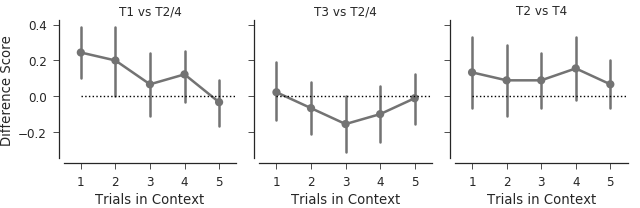

In [8]:
# plot the difference scores across time
df0 = df = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
                     (proc_data['Times Seen Context'] < 6)].copy()

score = list()

for uid in uids:
    subj_df = df0.loc[df0.subj == uid, :]

    if subj_df['Trial Number'].max() == df0['Trial Number'].max():

        grouped = subj_df.groupby(['Context', 'Times Seen Context']).mean()

        diff_1 = grouped.loc[6, 'Accuracy'] - 0.5 * (grouped.loc[7, 'Accuracy'] + \
                                                     grouped.loc[9, 'Accuracy'])
        diff_2 = grouped.loc[8, 'Accuracy'] - 0.5 * (grouped.loc[7, 'Accuracy'] + \
                                                     grouped.loc[9, 'Accuracy'])
        diff_3 = grouped.loc[7, 'Accuracy'] -  grouped.loc[9, 'Accuracy']
        diff_4 = grouped.loc[6, 'Accuracy'] -  grouped.loc[9, 'Accuracy']
        diff_5 = grouped.loc[8, 'Accuracy'] -  grouped.loc[7, 'Accuracy']


        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1 vs T2/4'] * n,
                    'Difference Score': diff_1,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T3 vs T2/4'] * n,
                    'Difference Score': diff_2,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T2 vs T4'] * n,
                    'Difference Score': diff_3,
                    'uniqueid': [uid] * n,
            }))


score = pd.concat(score)      
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1 vs T2/4'],  
                  ax=axes[0], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T3 vs T2/4'], 
                  ax=axes[1], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T2 vs T4'],  
                  ax=axes[2], color=[0.45, 0.45, 0.45])
    

    axes[0].set_xticklabels(range(1, 7))
    axes[0].set_ylabel('Difference Score')
    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    
    axes[0].set_title('T1 vs T2/4', fontdict={'size': 12})
    axes[1].set_title('T3 vs T2/4', fontdict={'size': 12})
    axes[2].set_title('T2 vs T4', fontdict={'size': 12})
    
    for ax in axes:
        ax.plot([0, 6], [0, 0], 'k:')
    
    plt.subplots_adjust(wspace=0.3)
    sns.despine(offset=5, trim=False)
    plt.tight_layout()
    plt.savefig('fig_exp1_supp_diff.pdf', dpi=300, bbox_inches='tight')

In [9]:
# run the bayesian GLM on the raw data

# create meaningful regressors
# really on only want to look at training
X0 = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
               (proc_data['Times Seen Context'] <= 5)].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 6, dtype=int) - \
     ((X0.Context.values == 7) | (X0.Context.values == 9))
    
x_2 = np.array(X0.Context.values == 8, dtype=int) - \
     ((X0.Context.values == 7) | (X0.Context.values == 9))
    
x_3 = np.array(X0.Context.values == 7, dtype=int) - \
     (X0.Context.values == 9)
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_1 = pm.Normal('beta_ctxT1vs24', mu=0., sd=100)
    b_2 = pm.Normal('beta_ctxT3vs24', mu=0., sd=100)
    b_3 = pm.Normal('beta_ctxT2vs4',  mu=0., sd=100)
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_1 * x_1 + b_2 * x_2 + b_3 * x_3 + \
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times, beta_ctxT2vs4, beta_ctxT3vs24, beta_ctxT1vs24]
100%|██████████| 2500/2500 [01:44<00:00, 24.02it/s]


In [10]:
# Compare model to a reduced model with out the contrasts
with pm.Model() as glm_reduced:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0.,   sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_reduced = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 2500/2500 [01:04<00:00, 38.66it/s]


In [12]:
df_comp_LOO = pm.compare((trace, trace_reduced, ),
                          (glm, glm_reduced), ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Flat',  'Reduced'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,warning
Flat,2907.41,93.62,0,0.8,42.33,0,1
Reduced,2922.06,88.43,14.65,0.2,40.73,9.83,1


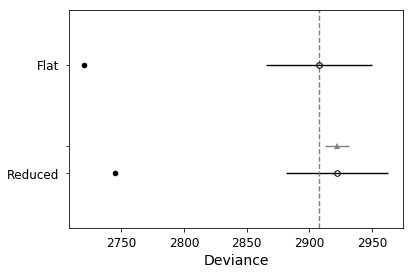

In [13]:
pm.compareplot(df_comp_LOO)

In [33]:
summary = pm.summary(trace, varnames=[
    'beta_ctxT1vs24', 'beta_ctxT3vs24', 'beta_ctxT2vs4',
    'beta_times', 'beta_reps', 'mu_subj'])
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_ctxT1vs24,0.314220,0.077735,0.001016,0.165574,0.471520,4000.0,1.000137
beta_ctxT3vs24,-0.244312,0.071936,0.000983,-0.376826,-0.102258,4000.0,1.000138
beta_ctxT2vs4,0.075352,0.066786,0.000704,-0.064655,0.196036,4000.0,0.999753
beta_times,0.431827,0.038567,0.001059,0.358381,0.506630,1129.0,1.000659
beta_reps,0.751692,0.138171,0.001576,0.480131,1.014225,4000.0,0.999800
mu_subj,-0.966367,0.133202,0.003538,-1.233269,-0.709213,1222.0,0.999897


In [35]:
#these are p-values
print "mimum p-value ", 1/2000.
print np.mean(trace['beta_ctxT1vs24'] < 0)
print np.mean(trace['beta_ctxT3vs24'] > 0)
print np.mean(trace['beta_ctxT2vs4'] < 0)
print np.mean(trace['beta_times'] < 0)
print np.mean(trace['beta_reps'] < 0)

mimum p-value  0.0005
0.0
0.0005
0.13225
0.0
0.0


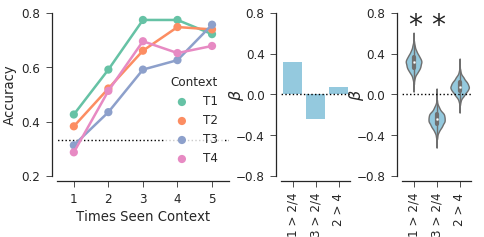

In [18]:
betas = pd.DataFrame({
        'T1vsT2/4': trace['beta_ctxT1vs24'],
        'T3vsT2/4': trace['beta_ctxT3vs24'],
        'T2vsT4':   trace['beta_ctxT2vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(7.43, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1, 1], wspace=0.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]))
    
    # show time series data as well
    df = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()
    
    ax=axes[0]
    sns.pointplot(x='Times Seen Context', y='Accuracy', hue='Context', #units='uniqueid',
                  estimator=np.mean, marker='.',
                  data=df[df['Times Seen Context'] < 6], palette='Set2', ax=ax, ci=None)

    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')

    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticklabels(range(1, 11))
    ax.set_ylabel('Accuracy')
    ax.plot([-1, 6], [1./3, 1./3], 'k:')
    ax.set_ylim([0.2, 0.8])
    sns.despine(offset=5)

    ax = axes[1]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=axes[1],
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[2]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})
    
    for ii in range(1, 3):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.8, -.4, 0, 0.4, 0.8])
        axes[ii].set_xlabel('')

    for ii, label in enumerate(['beta_ctxT1vs24', 'beta_ctxT3vs24','beta_ctxT2vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.22, 0.6), size=28)
    plt.savefig('exp1_fig_data.png', dpi=300, bbox_inches='tight')

# Paper Figures

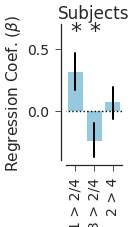

In [22]:

sns.set_context('paper', font_scale=1.75)


betas = pd.DataFrame({
        'T1vsT2/4': trace['beta_ctxT1vs24'],
        'T3vsT2/4': trace['beta_ctxT3vs24'],
        'T2vsT4':   trace['beta_ctxT2vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(1, 1, figsize=(1.0, 2.5))   

    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=ax,
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
    for ii, b in enumerate('beta_ctxT1vs24 beta_ctxT3vs24 beta_ctxT2vs4'.split()):
        ylb = summary.loc[b, 'hpd_2.5']
        yub = summary.loc[b, 'hpd_97.5']
        ax.plot([ii,ii], [ylb, yub], 'k', linewidth=2)
    
    ax.set_ylabel(r'Regression Coef. ($\beta$)')#, labelpad=)#, fontdict={'size': 16})#, 'weight': 'bold'})

    
    sns.despine(offset=5)

    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_xlabel('')
    ax.set_ylim([-0.4, 0.70])

    for ii, label in enumerate(['beta_ctxT1vs24', 'beta_ctxT3vs24', 'beta_ctxT2vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.27, 0.60), size=22)
            
    plt.title('Subjects',)
    plt.savefig('exp1_fig1b_data.png', dpi=300, bbox_inches='tight')

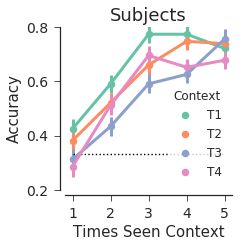

In [31]:
#within subject errorbars (standard error)
from matplotlib.ticker import NullFormatter  # useful for `logit` scale


cc = sns.color_palette('Set2')
def plot_test_context(ctx, ax, color, label):
    ctx = df.loc[(df['Times Seen Context'] < 6) & (df['Context'] == ctx), 'Accuracy'
                ].values.reshape(len(uids), -1)
    
    ctx_std_err = np.std(ctx - np.tile(ctx.mean(axis=1), (5, 1)).T - 
                         ctx.mean(), axis=0) / np.sqrt(len(uids))

    plt.plot(range(1, 6), ctx.mean(axis=0), color=color, label=label,
                linewidth=0, marker='.', markersize=15)
    (_, caps, _) = plt.errorbar(range(1, 6), ctx.mean(axis=0), ctx_std_err, color=color,
                linewidth=3)
    
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(3,3))
    plot_test_context(6, ax, cc[0], 'T1')
    plot_test_context(7, ax, cc[1], 'T2')
    plot_test_context(8, ax, cc[2], 'T3')
    plot_test_context(9, ax, cc[3], 'T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1, fontsize=12)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticks(range(1, 6))
    ax.set_xlabel('Times Seen Context', fontsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.plot([1, 5], [1./3, 1./3], 'k:')
    ax.set_ylim([0.2, 0.8])
    plt.gca().yaxis.set_minor_formatter(NullFormatter())

    plt.title('Subjects', fontsize=18, fontname='Helvetica')
    sns.despine(offset=5)
    
    
# plt.savefig('exp1_fig1a_data.png', dpi=300, bbox_inches='tight')

In [353]:
# asses accuracy on first trial in test contexts
# Do a "Bayesian Analysis" to follow up
# Generate the data
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)  & ~proc_data['Training'] ]

y_t1 = d0.loc[d0.Context == 6, 'Accuracy'].values 
y_t2 = d0.loc[d0.Context == 7, 'Accuracy'].values 
y_t3 = d0.loc[d0.Context == 8, 'Accuracy'].values 
y_t4 = d0.loc[d0.Context == 9, 'Accuracy'].values 


with pm.Model() as binom_model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    # define the likelihood
    y_t1 = pm.Bernoulli('y_t1', p=theta1, observed=y_t1)
    y_t2 = pm.Bernoulli('y_t2', p=theta2, observed=y_t2)
    y_t3 = pm.Bernoulli('y_t3', p=theta3, observed=y_t3)
    y_t4 = pm.Bernoulli('y_t4', p=theta4, observed=y_t4)
    
    # Generate a MCMC chain
    trace_bin = pm.sample(10000, pm.Metropolis())  # Use Metropolis sampling
    
print np.mean(trace_bin['theta1'] > 1/3.)
print np.mean(trace_bin['theta2'] > 1/3.)
print np.mean(trace_bin['theta3'] > 1/3.)
print np.mean(trace_bin['theta4'] > 1/3.)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta4_logodds__]
>Metropolis: [theta3_logodds__]
>Metropolis: [theta2_logodds__]
>Metropolis: [theta1_logodds__]
100%|██████████| 10500/10500 [01:23<00:00, 125.06it/s]


0.9803
0.8617
0.31735
0.1418


In [354]:
pm.summary(trace_bin)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.426829,0.046339,0.000398,0.334378,0.515044,12065.0,0.999970
theta2,0.382357,0.044768,0.000416,0.292967,0.467907,13584.0,0.999951
theta3,0.313464,0.043103,0.000404,0.230089,0.397908,12598.0,1.000186
theta4,0.286891,0.042576,0.000352,0.204161,0.368251,13629.0,1.000163


In [355]:
trace.varnames

['beta_ctxT1vs24',
 'beta_ctxT3vs24',
 'beta_ctxT2vs4',
 'beta_times',
 'beta_reps',
 'mu_subj',
 'sigma_sub_log__',
 'a_subj',
 'eps_log__',
 'sigma_sub',
 'eps']

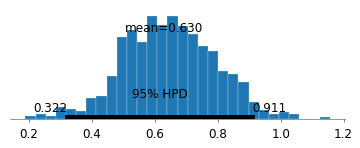

In [356]:
pm.plot_posterior(trace['beta_ctxT1vs24'] - trace['beta_ctxT3vs24'] + trace['beta_ctxT2vs4'])

In [357]:
np.mean((trace['beta_ctxT1vs24'] - trace['beta_ctxT3vs24'] + trace['beta_ctxT2vs4']) > 0)

1.0

In [36]:
rs = [np.corrcoef(trace_hier.beta_ctxT1vs24[ii, :], trace_hier.beta_ctxT3vs24[ii, :])[0][1] for ii in range(1000)]

-0.14467219027691058
0.935


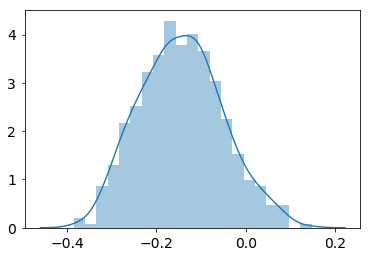

In [37]:
print np.mean(rs)
print np.mean(np.array(rs) < 0)
sns.distplot(rs)

In [37]:
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)
               & ~proc_data['Training'] ]
print set(d0.Context)

set([8.0, 9.0, 6.0, 7.0])


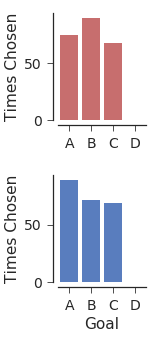

In [47]:
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(2, 1, sharey=True, figsize=(2.5, 5))

    d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==6) | (proc_data['Context']==9))]

    d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==7) | (proc_data['Context']==8)) ]

    cc = sns.color_palette('muted')
    sns.countplot(d0['Chosen Goal'], ax=axes[1], order='A B C D'.split(), color=cc[0])
    sns.countplot(d1['Chosen Goal'], ax=axes[0], order='A B C D'.split(), color=cc[2])
    
    for ii in [0, 1]:
        ax = axes[ii]
        ax.set_ylabel('Times Chosen')
    
    ax = axes[1]
    ax.set_xlabel('Goal')

    ax = axes[0]
    ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()

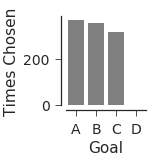

In [48]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.5, 2.5))

    d01 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)]


    cc = sns.color_palette('muted')
    sns.countplot(d01['Chosen Goal'], ax=ax, order='A B C D'.split(), color='grey')
    
    ax.set_ylabel('Times Chosen')
    
    ax.set_xlabel('Goal')
    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()

In [52]:
y_A_m0 = np.array(d0['Chosen Goal'].values == 'A') 
y_B_m0 = np.array(d0['Chosen Goal'].values == 'B') 
y_C_m0 = np.array(d0['Chosen Goal'].values == 'C') 

y_A_m1 = np.array(d1['Chosen Goal'].values == 'A') 
y_B_m1 = np.array(d1['Chosen Goal'].values == 'B') 
y_C_m1 = np.array(d1['Chosen Goal'].values == 'C') 


with pm.Model() as model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    
    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=theta1, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=theta2, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=theta3, observed=y_C_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=theta1, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=theta2, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=theta3, observed=y_C_m1)
    
    # Generate a MCMC chain
    trace = pm.sample(2000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta3_logodds__, theta2_logodds__, theta1_logodds__]
100%|██████████| 2500/2500 [00:13<00:00, 182.29it/s]


In [53]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.354795,0.022349,0.000278,0.311853,0.399613,4000.0,0.999751
theta2,0.349536,0.022145,0.000262,0.308047,0.395318,4000.0,1.000627
theta3,0.295634,0.021171,0.000246,0.255656,0.338142,4000.0,0.999784
